In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2

In [2]:
# Load the ResNet model
resnet_model = load_model('Final_InceptionV3_model.h5')

In [11]:
# Define the GradCAM function
from tensorflow.keras import backend as K

def mse_loss(y_true, y_pred, loss_function=None):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def gradcam(img, model, layer_name):
    # Expand the dimensions of the input image to represent the batch size
    img = tf.expand_dims(img, axis=0)
    
    # Retrieve the output of the specified layer for the input image
    last_conv_layer_output = model.get_layer(layer_name).output
    
    # Define a function to compute the gradient of the predicted class with respect to the activations of the last convolutional layer
    grad_model = Model([model.inputs], [model.output, last_conv_layer_output])
    
    with tf.GradientTape() as tape:
        preds, last_conv_layer_output = grad_model(img)
        class_output = preds[:, np.argmax(preds[0])]
        
    # Compute the gradients of the class output with respect to the activations of the last convolutional layer
    grads = tape.gradient(class_output, last_conv_layer_output)
    
    # Compute the vector of weights as the global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Compute the weighted combination of the activations of the last convolutional layer
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.reduce_mean(last_conv_layer_output * tf.expand_dims(pooled_grads, axis=0), axis=-1)
    
    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

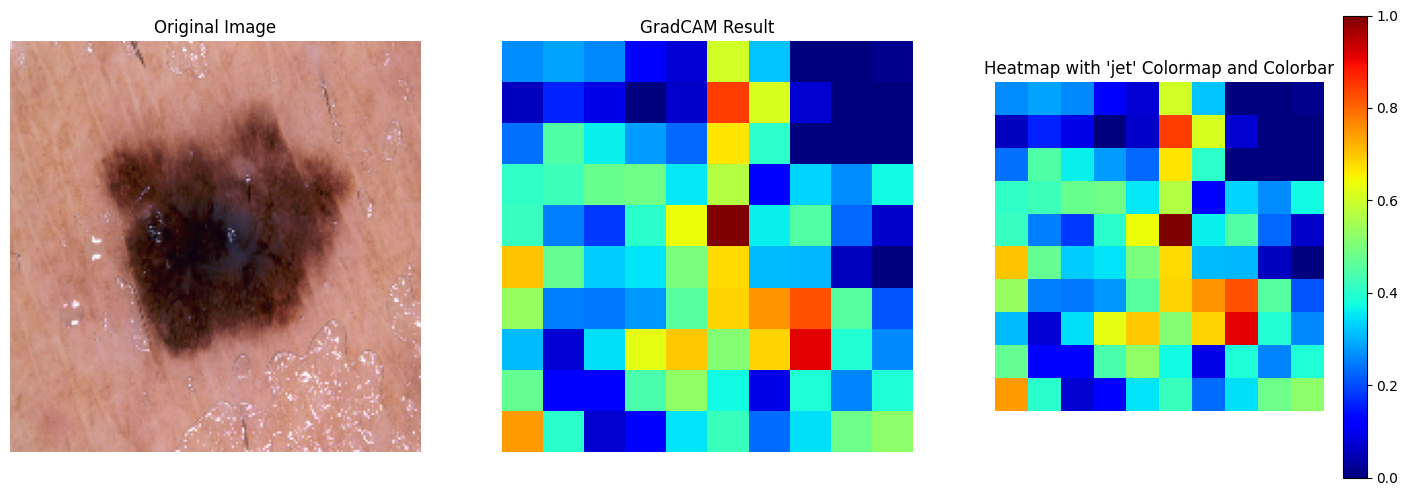

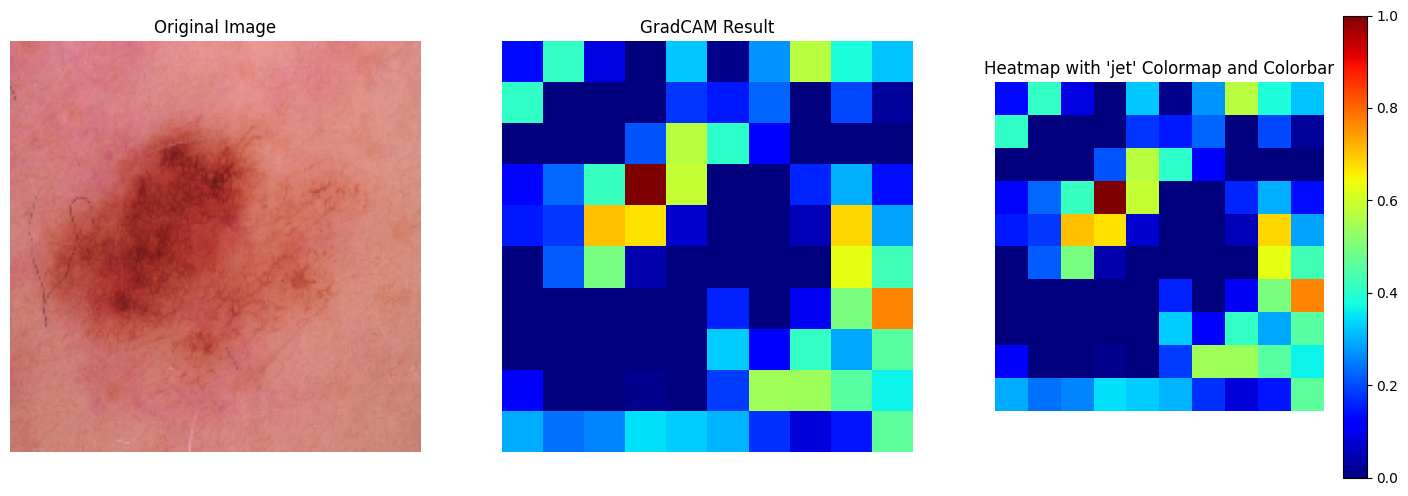

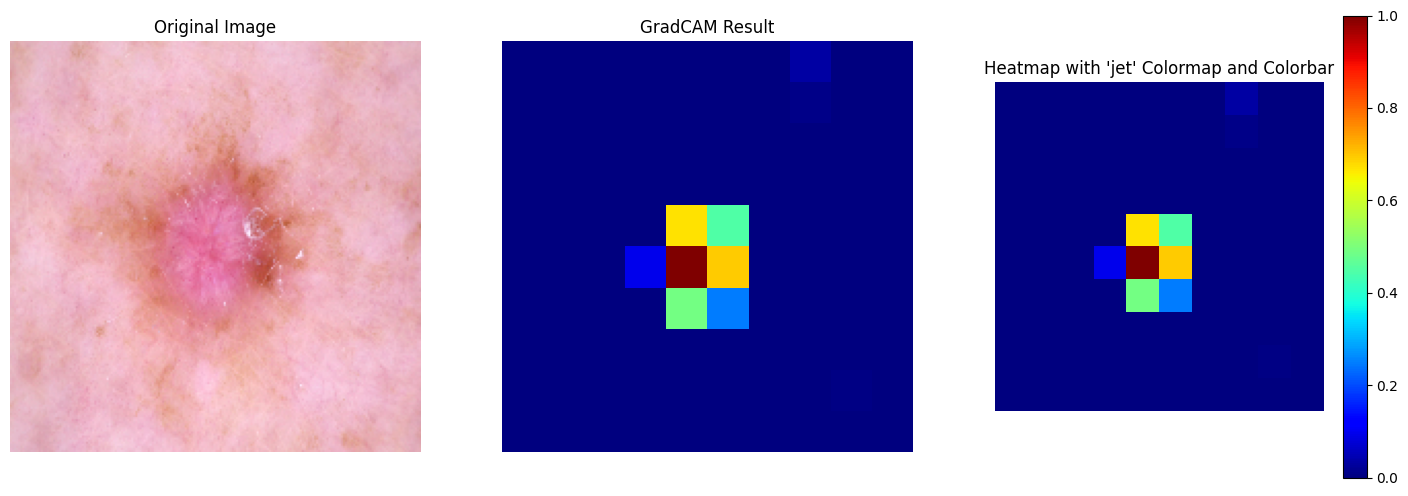

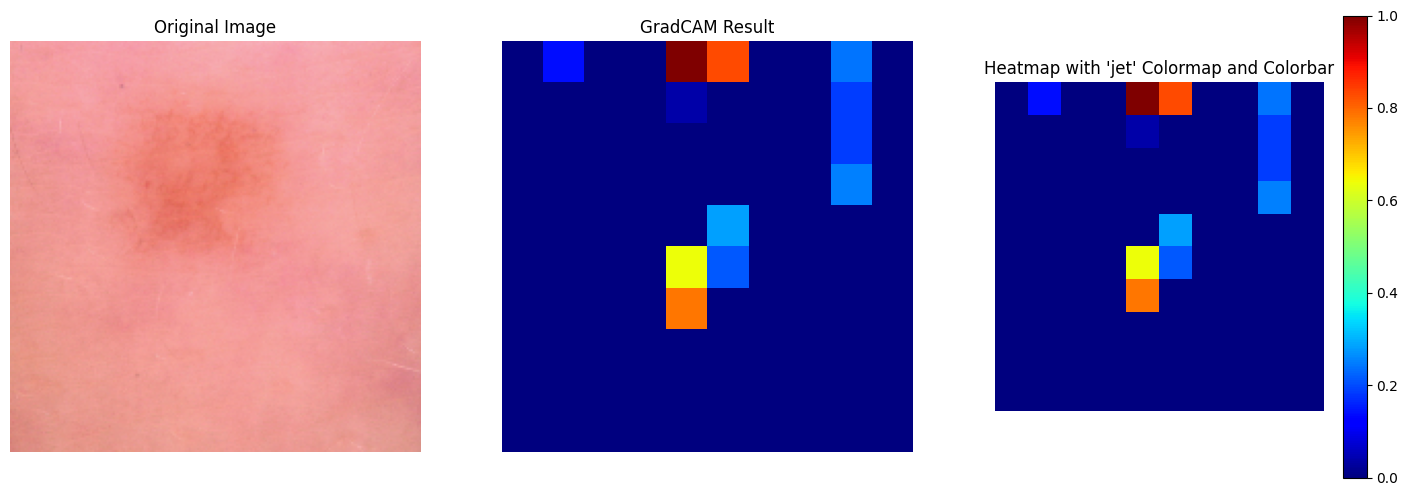

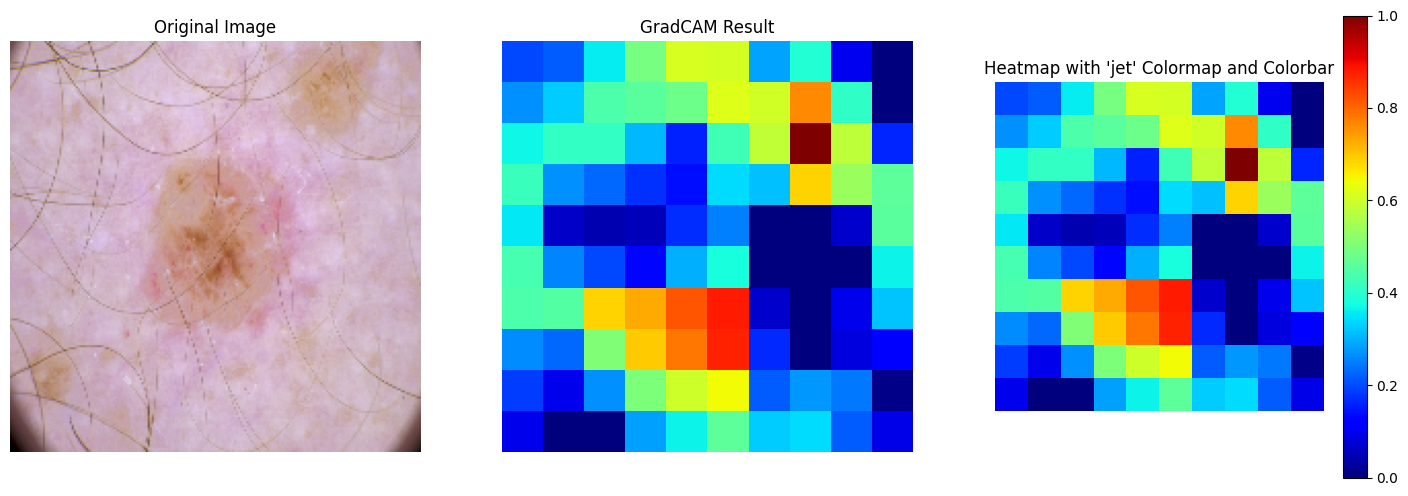

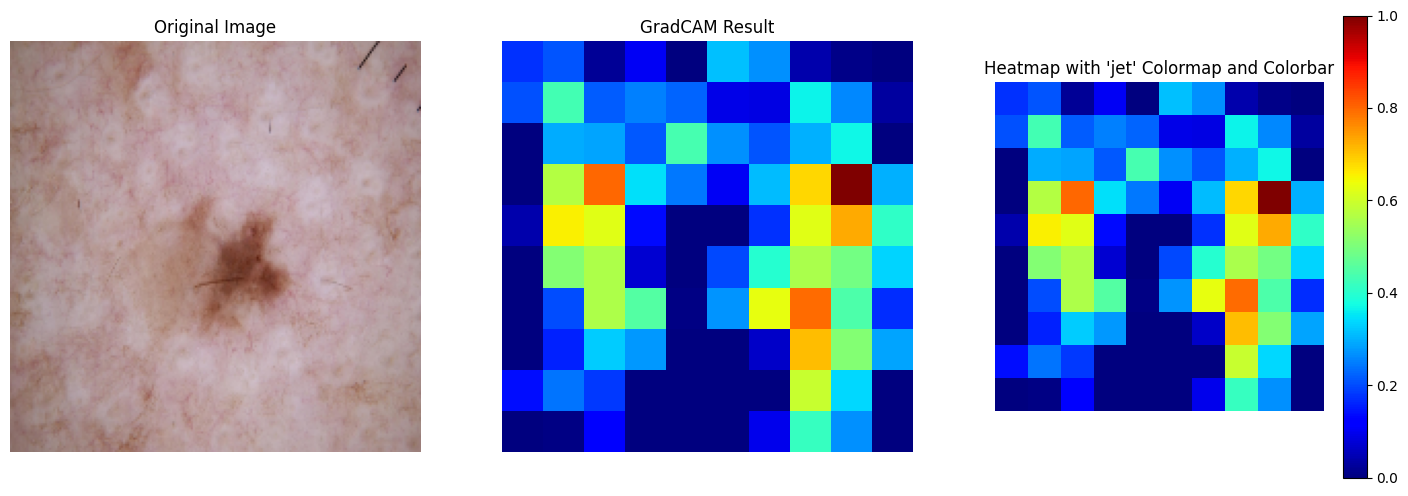

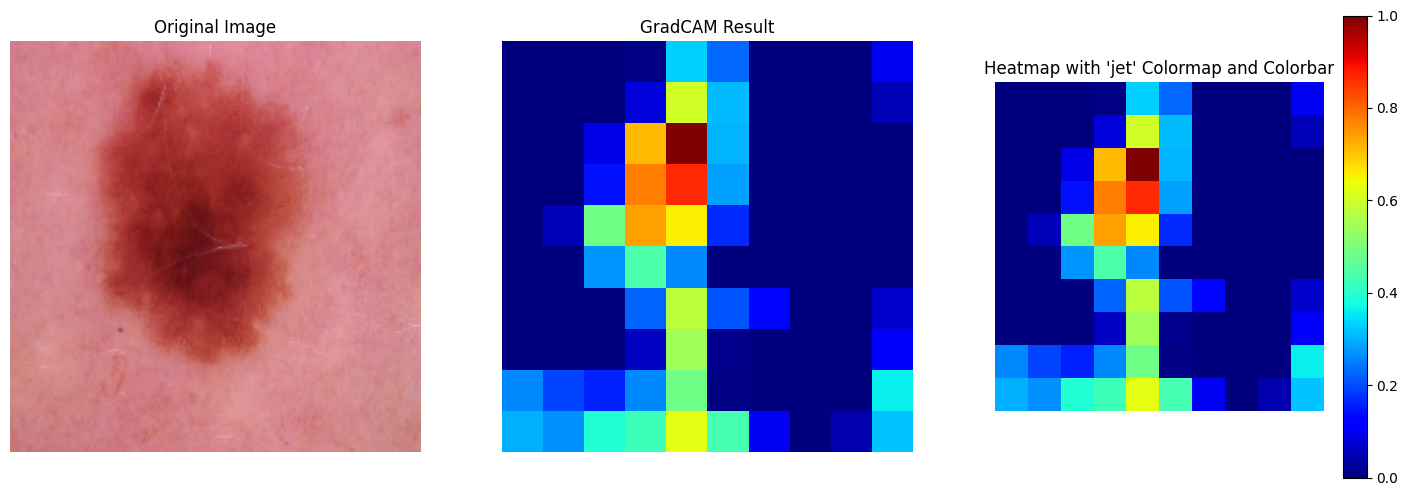

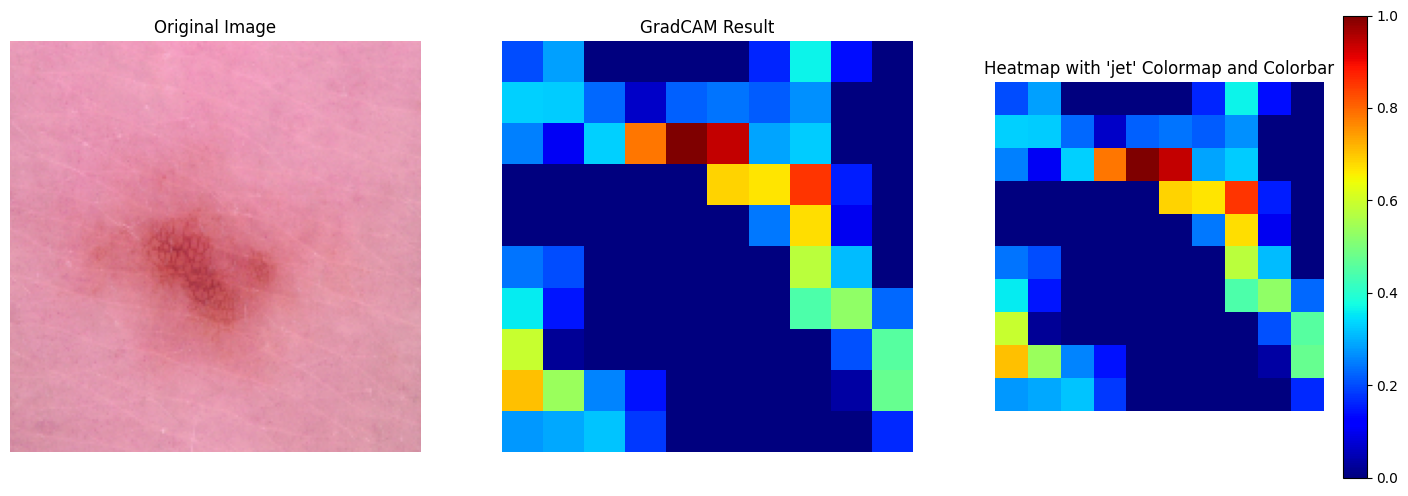

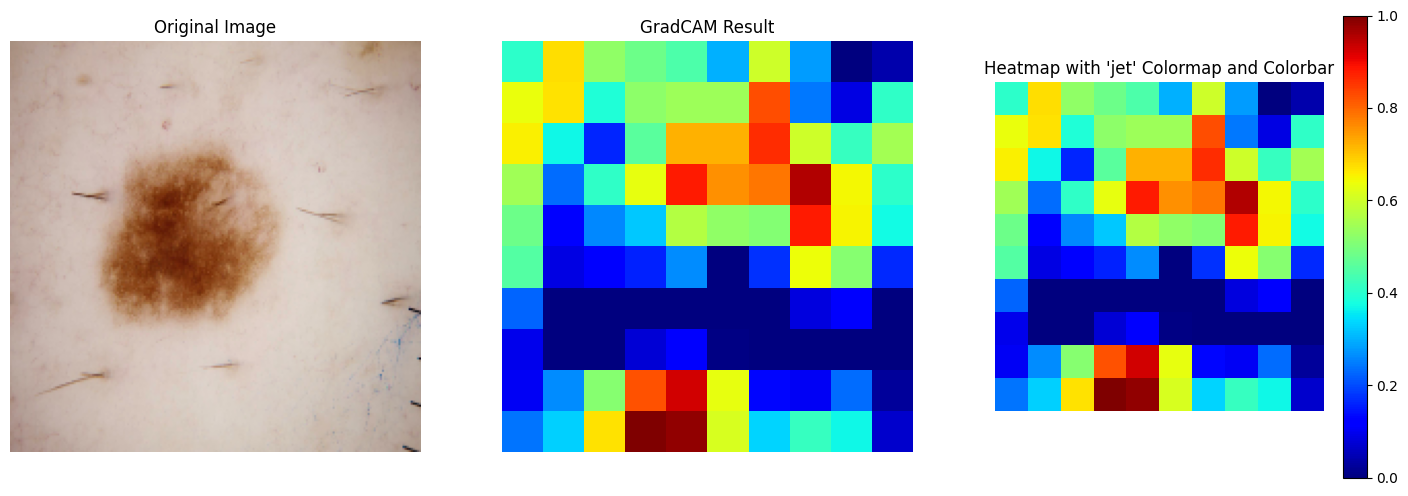

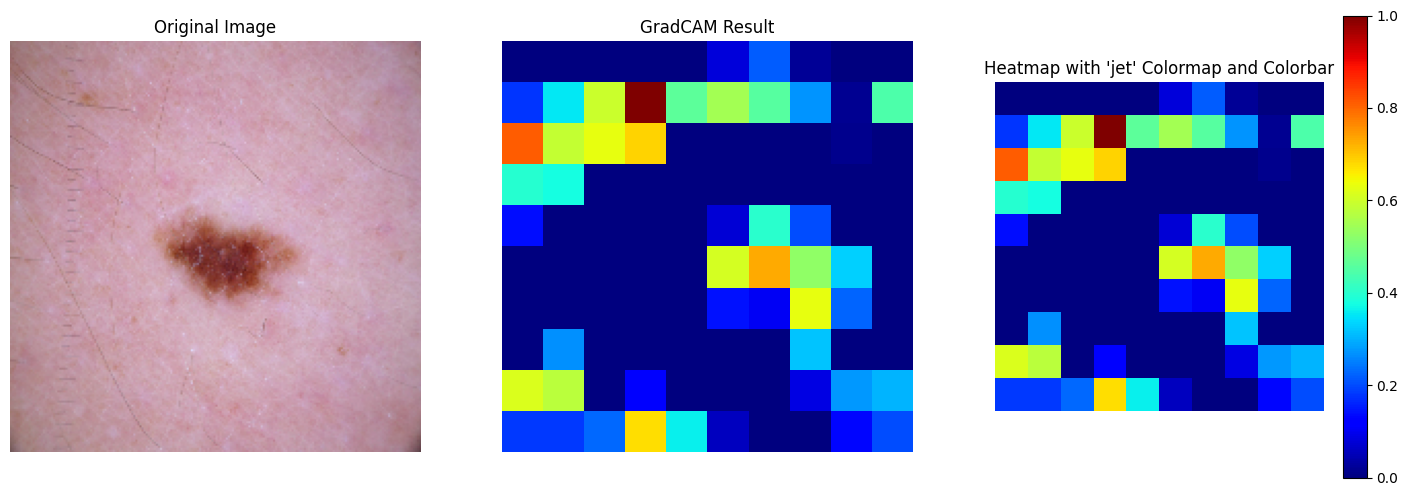

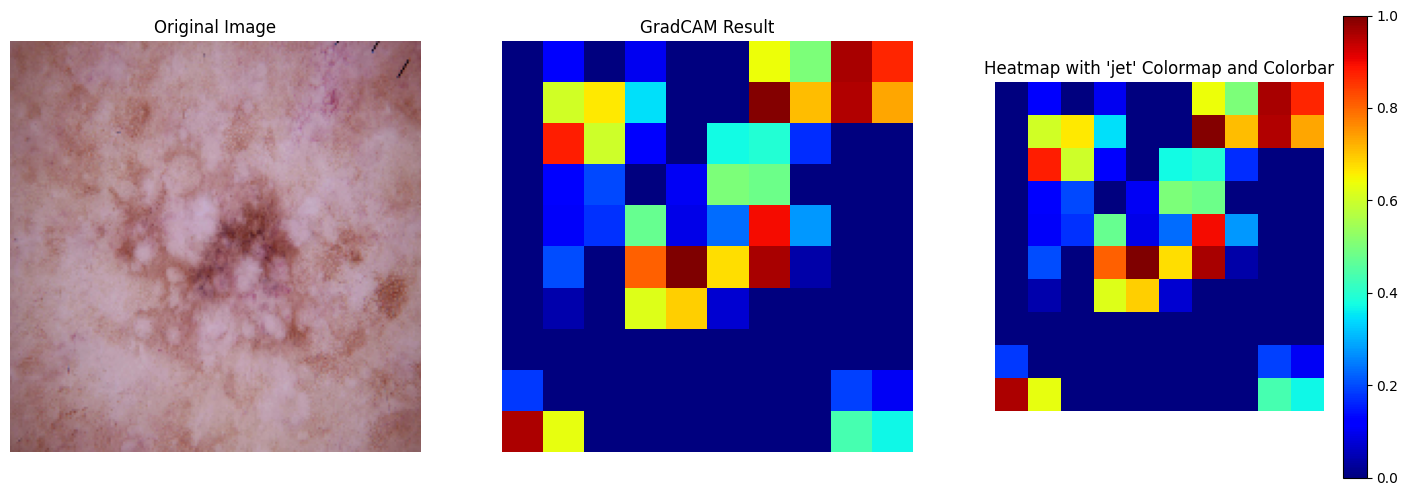

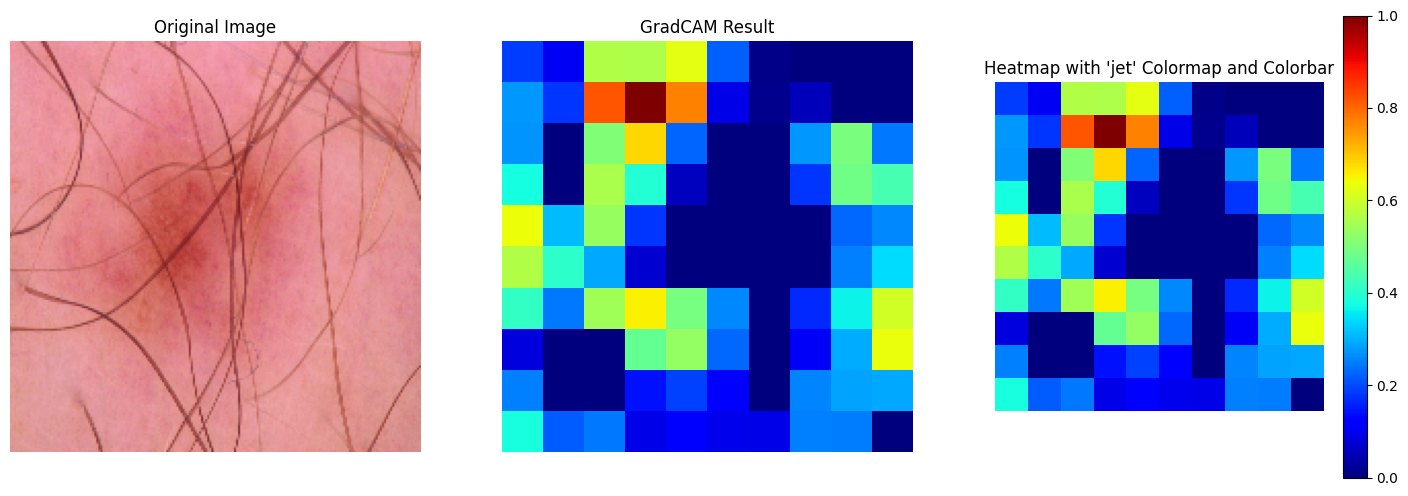

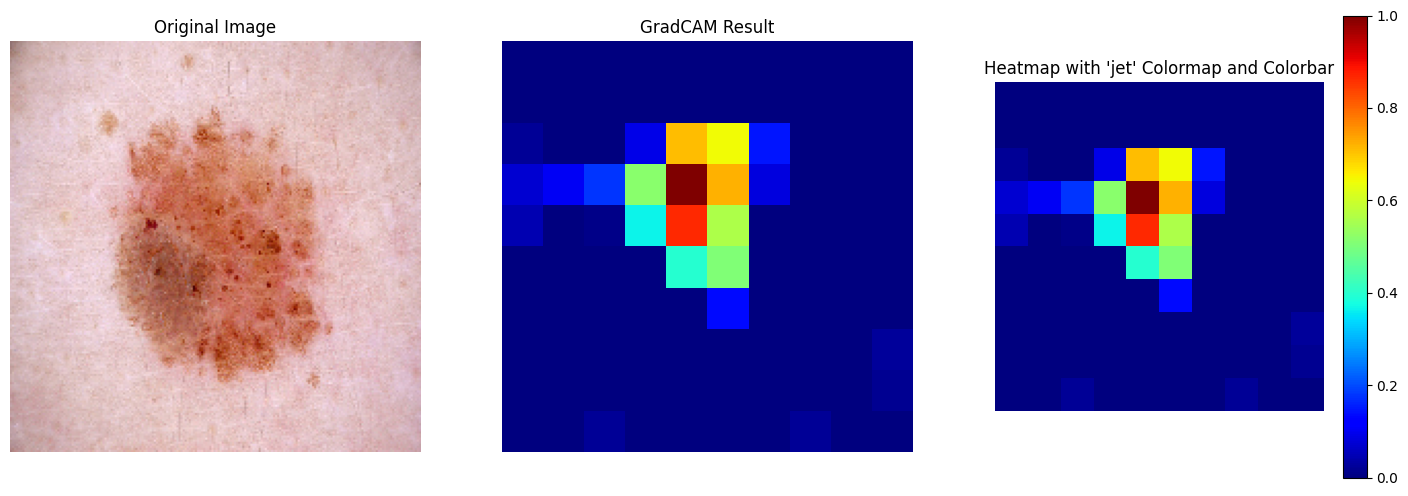

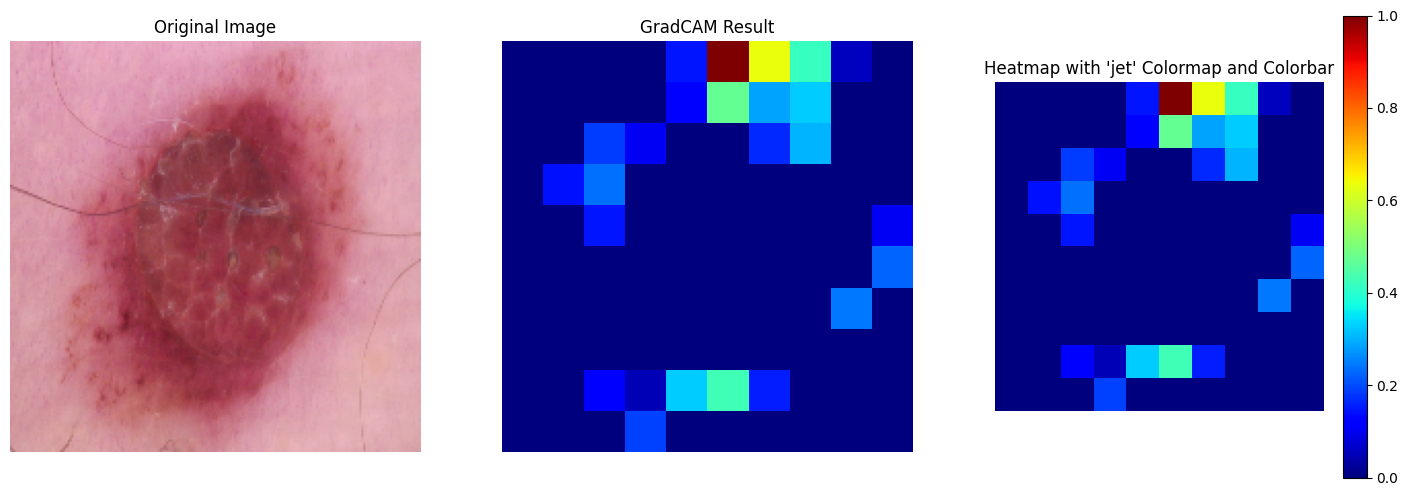

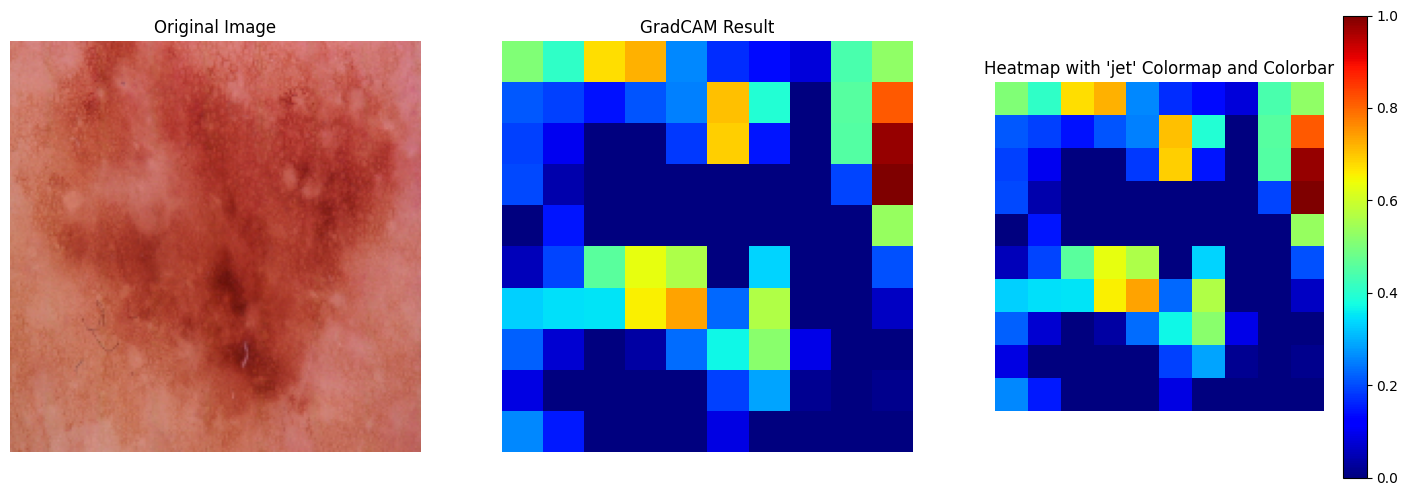

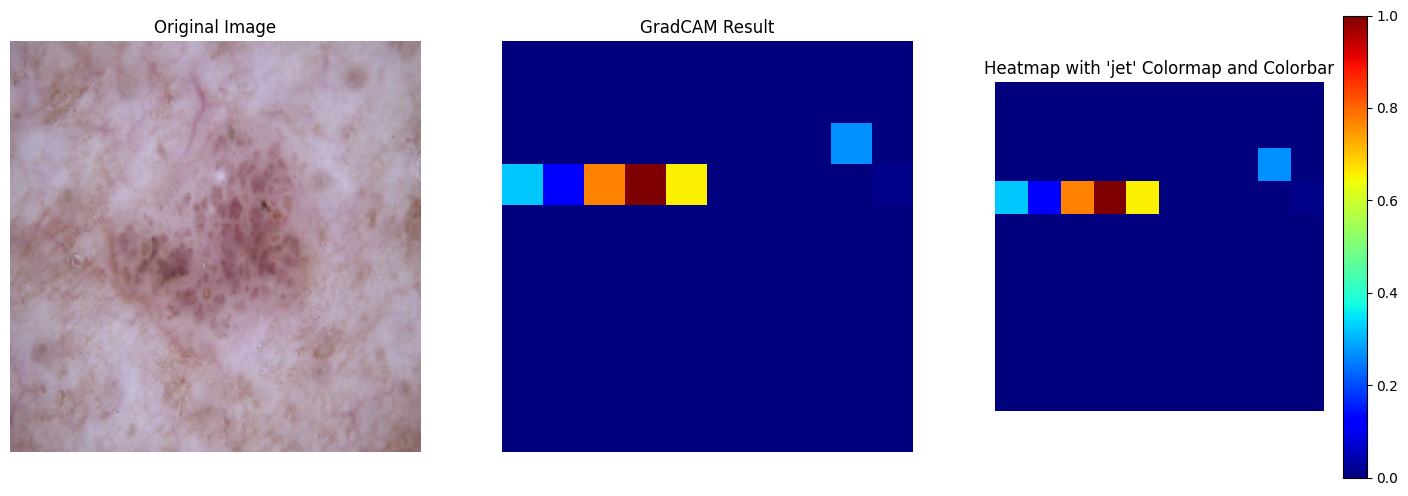

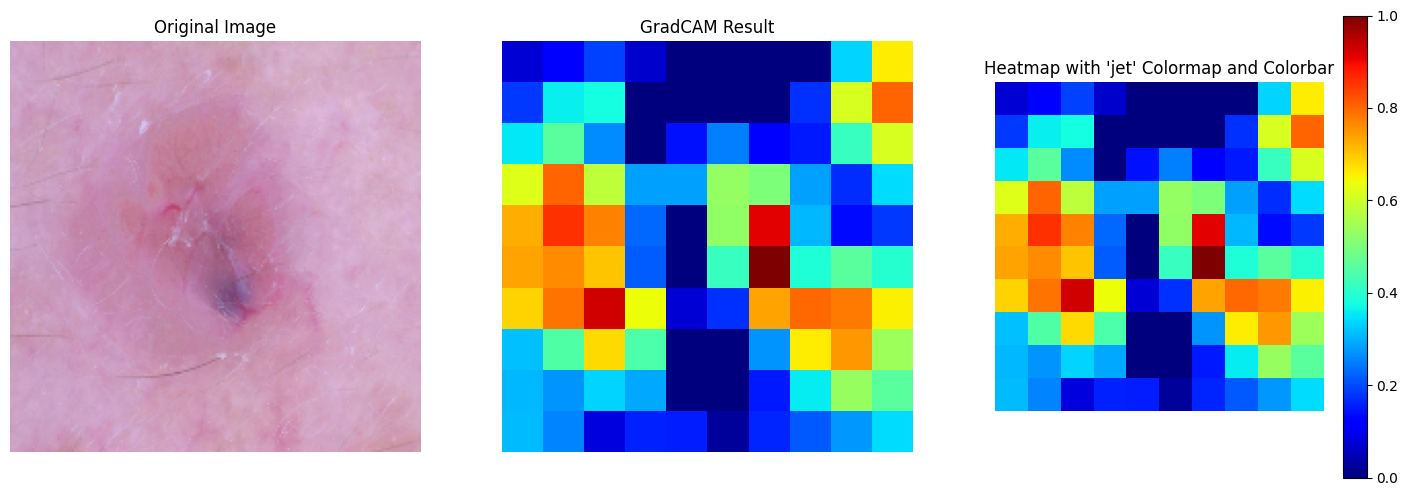

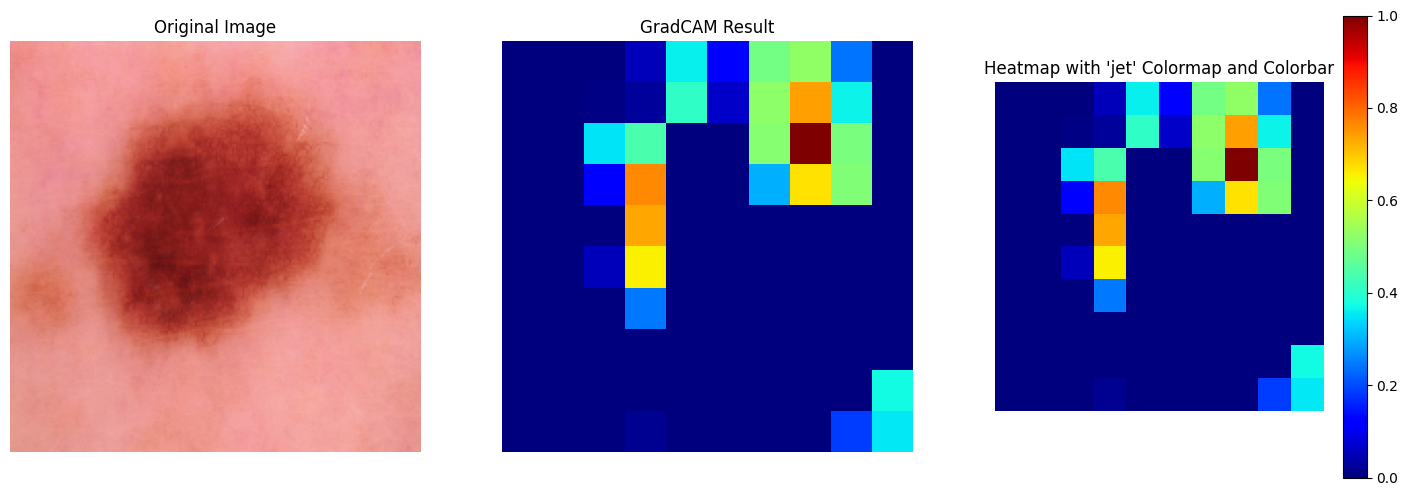

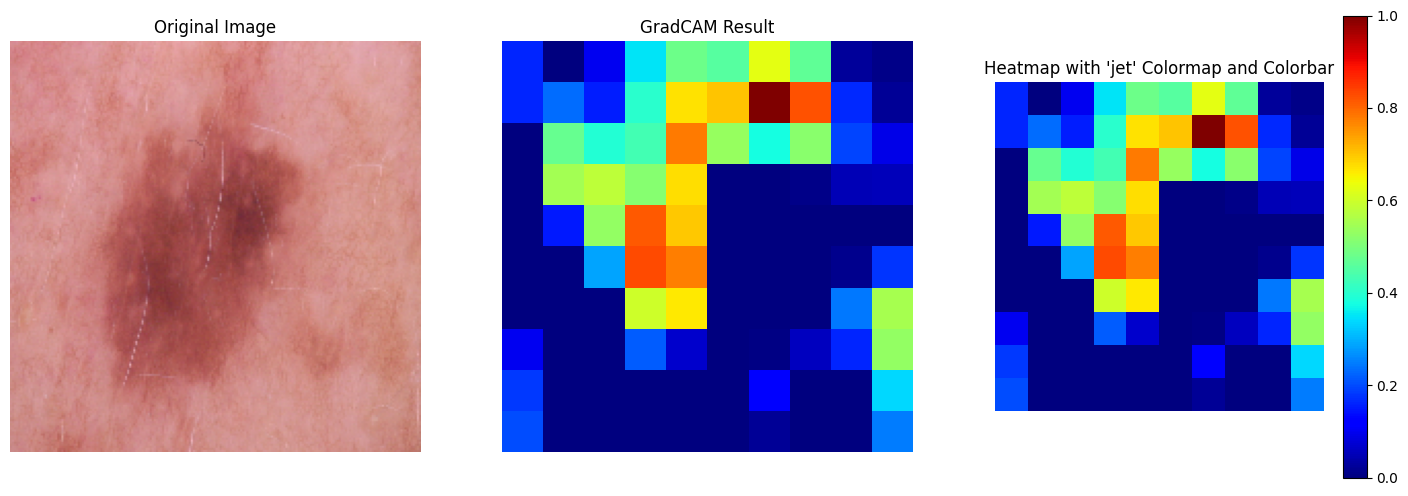

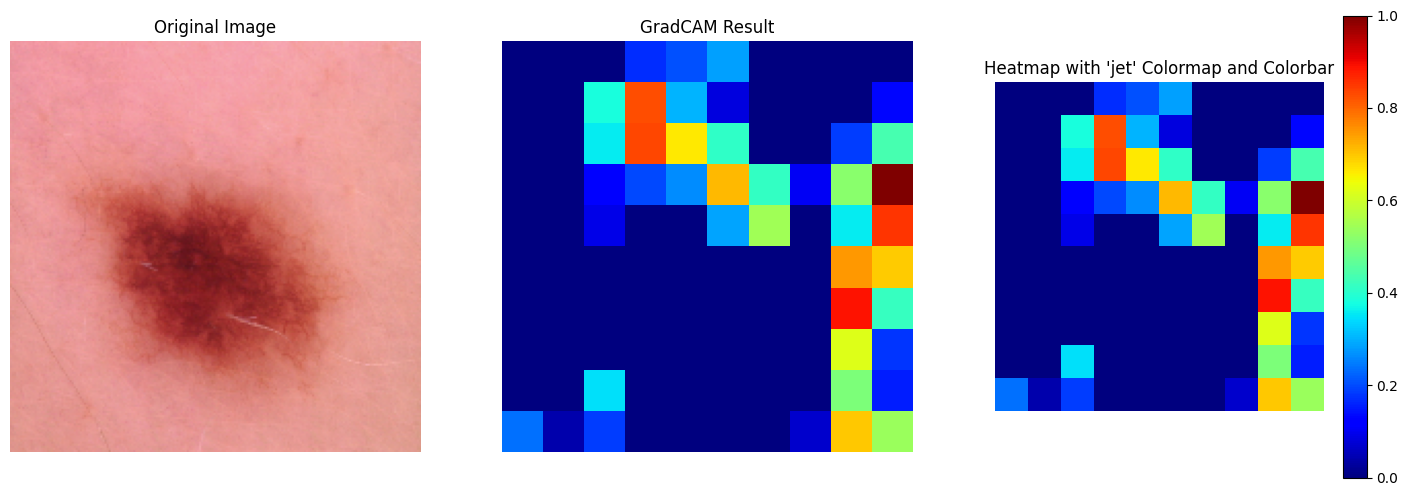

In [14]:
# Define the folder containing sample images
samples_folder = 'Samples/'

# Get the list of sample image files
sample_files = os.listdir(samples_folder)
img_size = (200, 200)

# Process each sample image
for sample_file in sample_files:
    img_path = os.path.join(samples_folder, sample_file)
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = img / 255.0  # Normalize
    # img_array = img_to_array(img)  # Convert the image to a NumPy array
    # img_array = preprocess_input(img_array)  # Preprocess the input for ResNet
    
     # Generate the GradCAM
    cam = gradcam(img, resnet_model, 'conv2d_621')
    
    # Display the original image, GradCAM, and heatmap with 'jet' colormap and colorbar
    plt.figure(figsize=(18, 6))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image")
    plt.axis('off')
    
    # GradCAM Result
    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title("GradCAM Result")
    plt.axis('off')
    
    # Heatmap Overlay
    plt.subplot(1, 3, 3)
    heatmap_plot = plt.imshow(cam, cmap='jet')
    plt.colorbar(heatmap_plot)
    plt.title("Heatmap with 'jet' Colormap and Colorbar")
    plt.axis('off')
    
    plt.show()

    
    # # Original Image
    # plt.subplot(1, 3, 1)
    # plt.imshow(img)
    # plt.title(f"Original Image")
    # plt.axis('off')
    
    # # GradCAM Result
    # plt.subplot(1, 3, 2)
    # plt.imshow(cam, cmap='jet')
    # plt.title("GradCAM Result")
    # plt.axis('off')
    
    # # Heatmap Overlay
    # plt.subplot(1, 3, 3)
    # heatmap_plot = plt.imshow(cam, cmap='jet')
    # plt.colorbar(heatmap_plot)
    # plt.title("Heatmap with 'jet' Colormap and Colorbar")
    # plt.axis('off')
    
    # plt.show()